In [ ]:
#conditional workflow : with llm
import os  # <--- Add this line
from langgraph.graph import StateGraph ,START, END
from typing import TypedDict ,Literal
from langchain_ollama import ChatOllama
from dotenv import load_dotenv
from pydantic import BaseModel , Field
import operator

In [3]:
load_dotenv()

True

In [4]:
ollama_url = os.getenv("OLLAMA_BASE_URL")

model = ChatOllama(
    model="llama3.2:latest", 
    base_url=ollama_url, 
    temperature=0
)

In [5]:
# 1.schema for structured output for sentiment
class sentimentsSchema(BaseModel):
    sentiment:Literal["positive","negative"]=Field( description='sentiment of the review')

#2.stuchured output for run diagonosis
class diagnosisSchema(BaseModel):
    issue_type : Literal["UX" , "Performance" , "Bug" , "Support" , "other"]=Field(description='The category of issued by the user')
    tone : Literal["angry" , "frustrated" , "disappointed" , "calm"]=Field(description='The emotional tone expressed by the user')
    urgency : Literal["low" , "medium" , "high"]=Field(description='How urgent or critical the issue appears to be')

In [6]:
#created model which return structure output 
stuctured_model = model.with_structured_output(sentimentsSchema)


stuctured_model2 = model.with_structured_output(diagnosisSchema)

In [7]:
prompt1 = 'what is the sentiment of the following review - the software too good'
#invoking structure model -> results stuctured output
stuctured_model.invoke(prompt1).sentiment


'positive'

In [ ]:
class ReviewState(TypedDict):
    review:str
    
    #output state
    sentiment:Literal["positive" , "negative"]#in  conditional flow this type of stste decide the next node to execute , thus we use Literals here
    diagnosis:dict
    response:str


In [9]:
def find_sentiments(state:ReviewState):
    prompt = f"what is the sentiment of the following review \n {state['review']}"
    sentiment=stuctured_model.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [10]:
#CONDITIONAL NODE : DECIDE WHICH FUNCTION TO RUN BASED ON SENTIMENT STATE
def check_setiments(state:ReviewState)->Literal["positive_response","run_diagnosis"]:

    if state['review']=='positive':
        return "positive_response"
    
    else:
        return "run_diagnosis"
    


    
def run_diagnosis(state:ReviewState):

    prompt =f""" Diagnosis this negative review :\n \n {state['review']}\n"
    "Return issue_type , tone and urgency.""" 

    response = stuctured_model2.invoke(prompt)

    return {'diagnosis':response.model_dump()}





def negative_response(state:ReviewState):

    diagnosis=state['diagnosis']

    prompt = f"""you are a support assitant.
    The user had a '{diagnosis['issue_type']} issue , sounded '{diagnosis['tone']}' , and marked urgency '{diagnosis['urgency']}'"""

    response=model.invoke(prompt)
    return{'response':response}






def positive_response(state:ReviewState):

    prompt=f"""Write a warm thannk-you message in response to this review \n\n "{state['review']}\" \n 
    Also, kindly ask the user to leave feedback on our website. """

    response=model.invoke("prompt")

    return {"response" : response}



In [11]:

graph=StateGraph(ReviewState)
graph.add_node('find_sentiments',find_sentiments)

graph.add_node("run_diagnosis" , run_diagnosis)
graph.add_node("positive_response", positive_response)
graph.add_node("negative_response", negative_response)

graph.add_edge(START , 'find_sentiments')
graph.add_conditional_edges('find_sentiments',check_setiments)

graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)
graph.add_edge('find_sentiments',END)

workflow = graph.compile()


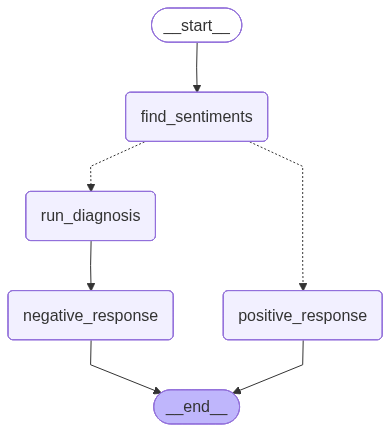

In [12]:
workflow

In [13]:
inital_state={
    'review':'The product was really bad'
}
workflow.invoke(inital_state)

{'review': 'The product was really bad',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'angry',
  'urgency': 'high'},
 'response': AIMessage(content="I've taken note of the user's concern.\n\n**Summary of Issue:**\n\n* Performance issue\n* Sounded angry (no specific details provided)\n* Marked urgency as high\n\n**Next Steps:**\n\n1. I'll review our system logs to see if there are any recent performance issues or errors that may have caused the user frustration.\n2. I'll check if there were any notifications or alerts sent to the user before they marked the issue as urgent, which might provide more context about what happened.\n3. If possible, I can try to gather more information from our system logs or other relevant data sources to help identify the root cause of the performance issue.\n\n**Potential Causes:**\n\n* Server overload or high traffic\n* Software glitch or bug\n* Network connectivity issues\n* Other (please specify)\n\nPlease let me know 